# Auto Price Prediction (part 2) - Combining ML & DL methods

This project is a continuation of [my previous project](https://github.com/artkel/skillfactory_rds/tree/main/module_6), in which I trained a machine learning model to predict used cars' prices based on their characteristics (manufacturer, brand, engine power, body type, fuel type, etc.) using data collected on the Internet.

This time, in addition to classical ML methods, we use RNN, CNN and Transfer Learning to try to improve the quality of predictions using visual and textual information from our dataset (car pictures and ads description).

This time, [all data is given](https://www.kaggle.com/c/sf-dst-car-price-prediction-part2/data), so we don’t have to parse it. **Mean absolute percentage error (MAPE)** is used as a loss function. 

I structured the project as previously to follow a standard DS workflow:

* Data preparation & cleaning
* Data analysis
* Baseline model
* Feature engineering
* Modelling (this part is now complemented with DL methods)

This project is also a part of this Kaggle competition: https://www.kaggle.com/c/sf-dst-car-price-prediction-part2/overview

### PREPARE PROBLEM

#### Necessary installations

In [ ]:
# !pip install catboost
# !pip install ipywidgets
# !pip install pymorphy2
# !pip install tensorflow_text
# !pip install catboost
# !pip install ipywidgets

#### Import necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import seaborn as sns

import random
import io
import zipfile

from catboost import CatBoostRegressor, Pool, metrics, cv
import nltk
from nltk.corpus import stopwords
from string import punctuation, digits
import pymorphy2 
import cv2

from albumentations import (
    HorizontalFlip, IAAPerspective, RandomContrast, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PowerTransformer


#### Check for available GPU
Note: I am using Google Colab environment for this project.

In [ ]:
!nvidia-smi

Sat Sep 18 17:55:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |  14690MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### PREPARE DATA

#### Downloading & preparing data

In [ ]:
!gdown --id '1idZUq-OoiZ0vwsGIr-CnhCaSL_Ommmrk'

Downloading...
From: https://drive.google.com/uc?id=1idZUq-OoiZ0vwsGIr-CnhCaSL_Ommmrk
To: /content/sf-dst-car-price-prediction-part2.zip
209MB [00:02, 87.3MB/s]


In [ ]:
def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
unzip_data('sf-dst-car-price-prediction-part2.zip')

In [ ]:
# create train & test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
# checking shapes of the datasets
train_df.shape, test_df.shape

((6682, 22), (1671, 21))

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

The most variables are categorical. Numeric variables are:
* `mileage`
* `modelDate` 
* `numberOfDoors`
* `productionDate`
* `sell_id`

Our target variable `price` is also numeric. Thus, we are dealing with a regression problem. 

In [ ]:
# shuffle train data
train_df = train_df.sample(frac=1, random_state=2077).reset_index(drop=True)

In [ ]:
# check a few rows
train_df.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,внедорожник 5 дв.,BMW,чёрный,«Inchcape Certified- Первый международный офи...,2.0 LTR,190 N12,дизель,8760,2017,X3,20d xDrive 2.0d AT (190 л.с.) 4WD,5,3125000.0,2020,1099116363,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
1,седан,BMW,чёрный,"Авто в отличном состоянии, я второй собственни...",2.5 LTR,218 N12,бензин,168000,2007,5ER,525i 2.5 AT (218 л.с.),4,850000.0,2009,1099915110,SEDAN AUTOMATIC 2.5,автоматическая,2 владельца,NaN,Оригинал,задний,Левый
2,седан,BMW,чёрный,"Автомобиль в прекрасном рабочем состоянии, сде...",4.4 LTR,450 N12,бензин,152000,2012,7ER,750Li xDrive 4.4 AT (450 л.с.) 4WD,4,1250000.0,2013,1095029130,SEDAN AUTOMATIC 4.4,автоматическая,2 владельца,NaN,Оригинал,полный,Левый
3,седан,BMW,чёрный,"Продам bmw 525 в кузове Е34, в редком лимитир...",2.5 LTR,192 N12,бензин,45000,1987,5ER,525i 2.5 AT (192 л.с.),4,2200000.0,1995,1097910892,SEDAN AUTOMATIC 2.5,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
4,седан,MERCEDES,белый,Mercedes Benz 2014года выпуска.........ПТС ори...,1.6 LTR,156 N12,бензин,135000,2014,C_KLASSE,180 1.6 AT (156 л.с.),4,1068000.0,2014,1100133868,SEDAN AUTOMATIC 1.6,автоматическая,3 или более,NaN,Оригинал,задний,Левый


In [ ]:
test_df.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,318i 2.0 AT (136 л.с.),4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый


In [ ]:
# label train set for further concatenation of train & test data
train_df['train'] = 1
test_df['train'] = 0
test_df['price'] = 0

In [ ]:
# concatenate train & test sets
df = pd.concat([train_df, test_df], ignore_index=False)

In [ ]:
df.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,train
0,внедорожник 5 дв.,BMW,чёрный,«Inchcape Certified- Первый международный офи...,2.0 LTR,190 N12,дизель,8760,2017,X3,20d xDrive 2.0d AT (190 л.с.) 4WD,5,3125000.0,2020,1099116363,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,1
1,седан,BMW,чёрный,"Авто в отличном состоянии, я второй собственни...",2.5 LTR,218 N12,бензин,168000,2007,5ER,525i 2.5 AT (218 л.с.),4,850000.0,2009,1099915110,SEDAN AUTOMATIC 2.5,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,1
2,седан,BMW,чёрный,"Автомобиль в прекрасном рабочем состоянии, сде...",4.4 LTR,450 N12,бензин,152000,2012,7ER,750Li xDrive 4.4 AT (450 л.с.) 4WD,4,1250000.0,2013,1095029130,SEDAN AUTOMATIC 4.4,автоматическая,2 владельца,NaN,Оригинал,полный,Левый,1
3,седан,BMW,чёрный,"Продам bmw 525 в кузове Е34, в редком лимитир...",2.5 LTR,192 N12,бензин,45000,1987,5ER,525i 2.5 AT (192 л.с.),4,2200000.0,1995,1097910892,SEDAN AUTOMATIC 2.5,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1
4,седан,MERCEDES,белый,Mercedes Benz 2014года выпуска.........ПТС ори...,1.6 LTR,156 N12,бензин,135000,2014,C_KLASSE,180 1.6 AT (156 л.с.),4,1068000.0,2014,1100133868,SEDAN AUTOMATIC 1.6,автоматическая,3 или более,NaN,Оригинал,задний,Левый,1


In [ ]:
df.shape

(8353, 23)

In [ ]:
# check cardinality of categorical variables
df.select_dtypes(["category", "object"]).nunique().sort_values()

ПТС                        2
Руль                       2
brand                      3
Владельцы                  3
Привод                     3
fuelType                   4
vehicleTransmission        4
color                     16
bodyType                  17
engineDisplacement        48
model_info               122
enginePower              154
Владение                 180
vehicleConfiguration     312
name                     976
description             7654
dtype: int64

As we can see, there are a few categorical variables with a lot of unique values. We should keep it in mind when choosing encoding techniques.

#### Data cleaning

In [ ]:
# check for missing values
df.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
train                      0
dtype: int64

We have two predictors with missing values: `Владение` (ownership) and `Владельцы` (owners). There are more than 50% values missing in `Владение`. We will drop this feature. There are two more variables with little information: `name` and `vehicleConfiguration`. We can get rid of them as well. 

In [ ]:
df.drop(['name', 'vehicleConfiguration', 'Владение'], 1, inplace=True)

Let's now extract numeric information from the 'enginePower' variable, so that it becomes a numeric feature.

In [ ]:
df['enginePower'] = df.enginePower.apply(lambda x: float(x.split(' ')[0]))

As a next step, we will rename our predictors for more convenience.

In [ ]:
df.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'train'],
      dtype='object')

In [ ]:
# rename columns for convenience
df.columns = ['body_type', 'brand', 'color', 'description', 'en_vol',
              'en_power', 'fuel', 'mileage', 'model_date', 'model', 
              'num_doors', 'price', 'prod_date', 'sell_id', 'transmission',
              'owners', 'pts', 'drive', 'wheel', 'train']

In [ ]:
# check a few rows
df.sample(5)

,body_type,brand,color,description,en_vol,en_power,fuel,mileage,model_date,model,num_doors,price,prod_date,sell_id,transmission,owners,pts,drive,wheel,train
1593,внедорожник 5 дв.,BMW,белый,Выгода до 82 000 руб. при обмене на Ваш автомо...,3.0 LTR,306.0,бензин,43536,2013,X5,5,3055000.0,2017,1099838720,автоматическая,1 владелец,Оригинал,полный,Левый,1
4651,внедорожник 5 дв.,MERCEDES,коричневый,Авто в отличном состоянии. В салоне не курили....,2.1 LTR,170.0,дизель,105000,2008,GLK_KLASSE,5,1030000.0,2012,1094087470,автоматическая,2 владельца,Оригинал,полный,Левый,1
5668,внедорожник 5 дв.,BMW,синий,"Отличный ИКС, сделанный с душой, немцами и м...",4.8 LTR,360.0,бензин,300000,2003,X5,5,830000.0,2005,1099703092,автоматическая,3 или более,Оригинал,полный,Левый,1
4901,седан,AUDI,синий,Авто для своих лет внешне и тех состоянии на т...,2.0 LTR,200.0,бензин,200000,2004,A4,4,420000.0,2007,1087060247,вариатор,2 владельца,Оригинал,передний,Левый,1
1654,внедорожник 5 дв.,BMW,оранжевый,Безопасность: 7. Мультимедиа: 2. Комфорт: 11. ...,2.0 LTR,150.0,бензин,72000,2012,X1,5,950000.0,2013,1089786340,автоматическая,1 владелец,Оригинал,задний,Левый,1


We still have one missing value in the variable `owners`. Let's investigete the observation a bit further.

In [ ]:
# how old is the vehicle?
df[df.owners.isna()==True][['model_date', 'prod_date']]

,model_date,prod_date
1042,1999,2001


In [ ]:
# check the description for more insights
df[df.owners.isna()==True].description.to_list()

['машина в идеале! вложено примерно 400тыс.руб \r\n замена ГРМ, всех расходников,\r\n двигатель контрактный с пробегом в 120,000км.\r\n рулевая рейка новая (не ремонтная а НОВАЯ!)\r\n новый кардан. \r\n новые гидро натяжители цепей 40тыс.руб. \r\n новый бензонасос, \r\n новая подвеска "бильштайн" \r\n и т.д. \r\n комплектация максимальная- черное дерево! штатный (снимаемый) фаркоп, предпусковой подогреватель WEBASTO, кованные диски (германия) R-20, телефон.\r\nНА ВТОРОМ ФОТО СТАРЫЙ РУЛЬ! СЕЙЧАС НОВЫЙ С ДЕРЕВОМ КАК НА ПОСЛЕДНИХ ФОТО... (старый отдам в довесок)\r\nнедавно сделана полная разводка глушителей, с установкой новых банок на обе трубы (на фото можно разглядеть снизу) банки от ренж ровер спорт, звук КЛАСС!!!\r\n много писать, звоните...\r\nфото 100% мои!\r\nвозможен обмен на битый или горевший  микроавтобус (фольксваген Т-5) мультиван свежих годов.\r\nСАЛОНЫ И ПРОЧИЕ "ПОМОЩНИКИ" ИДИТЕ ЛЕСОМ!!!!!!!!!\r\nфото 100% мои!\r\nпродажа НЕ срочная!!! с большим торгом не звонить.']

Ok, it seems like we are dealing with quite an old vehicle here, which could imply a high number of owners. Let's check our hypothesis by visualizing the data.

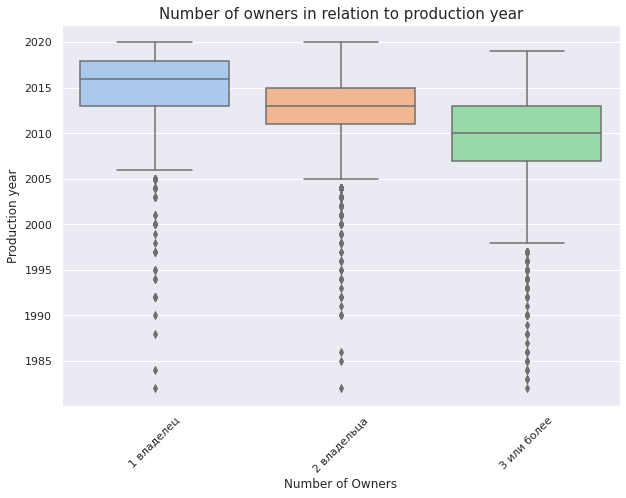

In [ ]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="owners", y="prod_date", data=df, palette = "pastel")
plt.title("Number of owners in relation to production year", fontsize=15)
plt.xticks(rotation='45')
plt.xlabel('Number of Owners')
plt.ylabel('Production year')
plt.show()

It seems like vehicles produced prior to 2010 tend to have 3 or more owners. We will for the `fillna` method.

In [ ]:
# filling the missing value
df['owners'].fillna('3 или более', inplace=True)

In [ ]:
df.isna().sum()

body_type       0
brand           0
color           0
description     0
en_vol          0
en_power        0
fuel            0
mileage         0
model_date      0
model           0
num_doors       0
price           0
prod_date       0
sell_id         0
transmission    0
owners          0
pts             0
drive           0
wheel           0
train           0
dtype: int64

Nice! We now have zero missing values in our dataset!

As part of data cleaning, we should also check & trim the outliers. However, given a rather small dataset to work with, we will skip that part. We could consider using `RobustScaler` to deal with outliers.

Lastly, let's check whether our train dataset contains duplicates

In [ ]:
# check for duplicates
train_df.duplicated().sum()

0

### EXPLORATORY DATA ANALYSIS

Please, check my [previous project](https://github.com/artkel/skillfactory_rds/tree/main/module_6) with similar data for more comprehensive EDA.

#### Descriptive statistics

In [ ]:
df[df.train==1].drop(['sell_id', 'train'], 1).describe()

,en_power,mileage,model_date,num_doors,price,prod_date
count,6682.000000,6682.000000,6682.000000,6682.000000,6.682000e+03,6682.000000
mean,255.788686,120522.610895,2010.135588,4.268482,1.899868e+06,2012.031577
std,109.240110,81454.448294,5.370973,0.878687,1.914153e+06,5.049676
min,75.000000,1.000000,1975.000000,2.000000,3.013010e+05,1982.000000
25%,184.000000,59181.250000,2007.000000,4.000000,8.000000e+05,2009.000000
50%,231.000000,111000.000000,2011.000000,4.000000,1.300000e+06,2013.000000
75%,306.000000,168000.000000,2014.000000,5.000000,2.299283e+06,2016.000000
max,639.000000,999999.000000,2019.000000,5.000000,2.390000e+07,2020.000000


Some observations:

* median mileage lies above 110.000 km with the highest value of 1.000.000 km
* mean engine power is 255 hp
* the oldest vehicle in the dataset was produced in 1982, whereas the vehicles are 8 years old on average 
* median price is around 1.3 mln Rub, with the highest value of 24 mln Rub and the bottom of around 300.000 Rub
+ we can also observe the mismatch between mean & median for almost all of our numeric variables, indicating diviations from the normal distribution (will check it later on)

#### Unimodal data analysis

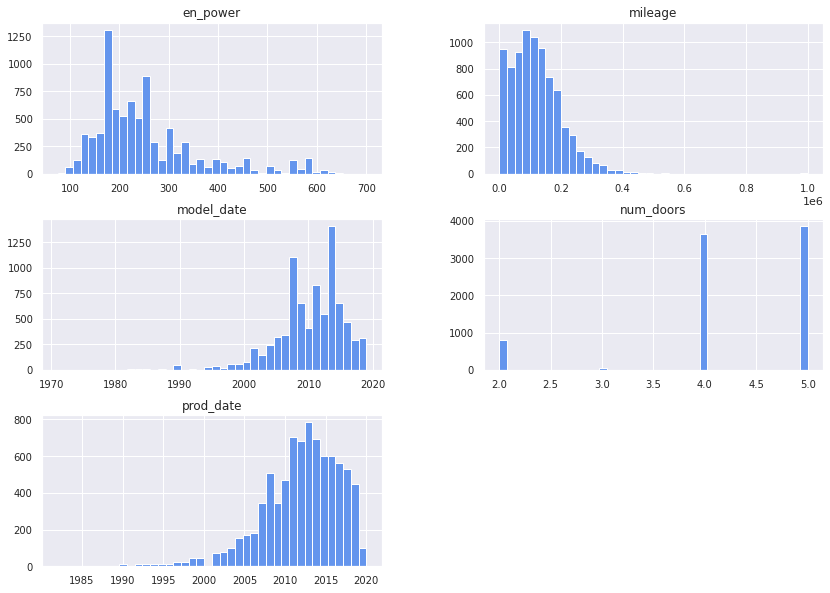

In [ ]:
num_var = df.select_dtypes(include=['float64', 'int64']).drop(['sell_id', 'price', 'train'], 1).columns.to_list()

df.loc[:, num_var].hist(sharex=False, sharey=False, bins=40, xlabelsize=10, ylabelsize=10, 
                                                    figsize=(14, 10), color='cornflowerblue')
plt.show()

* none of our numeric features has a Gaussian distribution, so we might consider power transforms like the *Box-Cox* transform or the *Yeo-Johnson*
* the distribution of variable `mileage` resembles lognormal or Weibull distribution
* the vast majority of cars in the dataset were produced after 2000. However, there are also a few older vehicles for sale

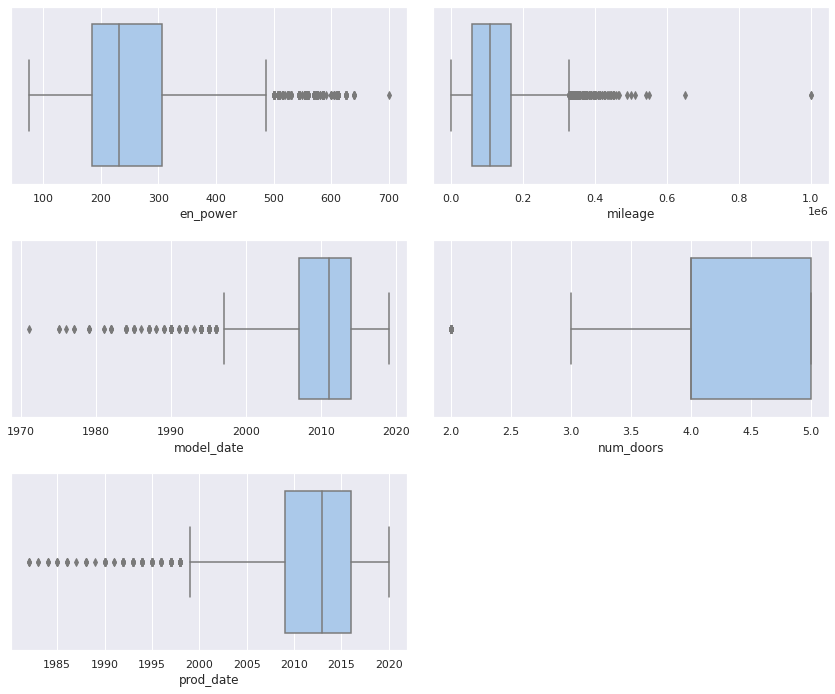

In [ ]:
fig = plt.figure(figsize=(12, 10))

for index, col in enumerate(num_var):
    plt.subplot(3, 2, index+1)
    f = sns.boxplot(x=col, data=df, palette = "pastel")
fig.tight_layout(pad=2.0)

On the boxplots, we can see some outliers. As already mentioned, we will deal with them by means of `RobustScaler` when it comes to data normalization further on.

Now, let's take a closer look at distribution of our output variable - `price`.

In [ ]:
# reinstantiate train & test datasets
train_df = df[df.train==1]
test_df = df[df.train==0]

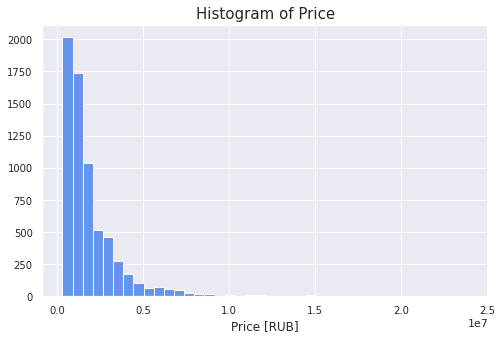

In [ ]:
df[df.train==1]['price'].hist(bins=40, xlabelsize=10, ylabelsize=10, figsize=(8, 5), color='cornflowerblue')
plt.title("Histogram of Price", fontsize=15)
plt.xlabel("Price [RUB]")
plt.show()

The distribution our target seems to be exponential; we could try `np.log` it for potentially better models' performance.

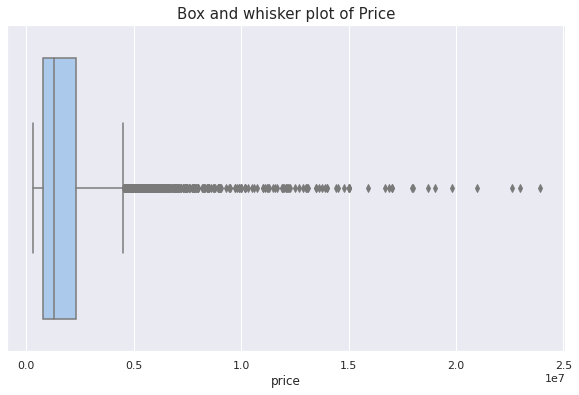

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="price", data=df[df.train==1], palette = "pastel")
plt.title("Box and whisker plot of Price", fontsize=15)
plt.show()

As we can see, there are quite a few values lying above 1.5 * IQR. Let's get rid of observations with prices above 10 mln RUB

In [ ]:
print(f'There are {df[df.price>10000000].shape[0]} vehicles with prices above 10 mln Rub')

There are 63 vehicles with prices above 10 mln Rub


I guess, we can afford to lose 63 observations from our dataset...

In [ ]:
df = df[df.price<=10000000]
df.shape, df[df.train==0].shape

((8290, 20), (1671, 20))

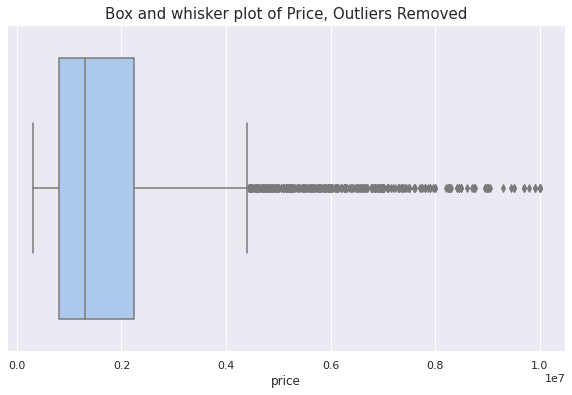

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="price", data=df[df.train==1], palette = "pastel")
plt.title("Box and whisker plot of Price, Outliers Removed", fontsize=15)
plt.show()

Looks much better!

Let's now visualize some of our categorical variables

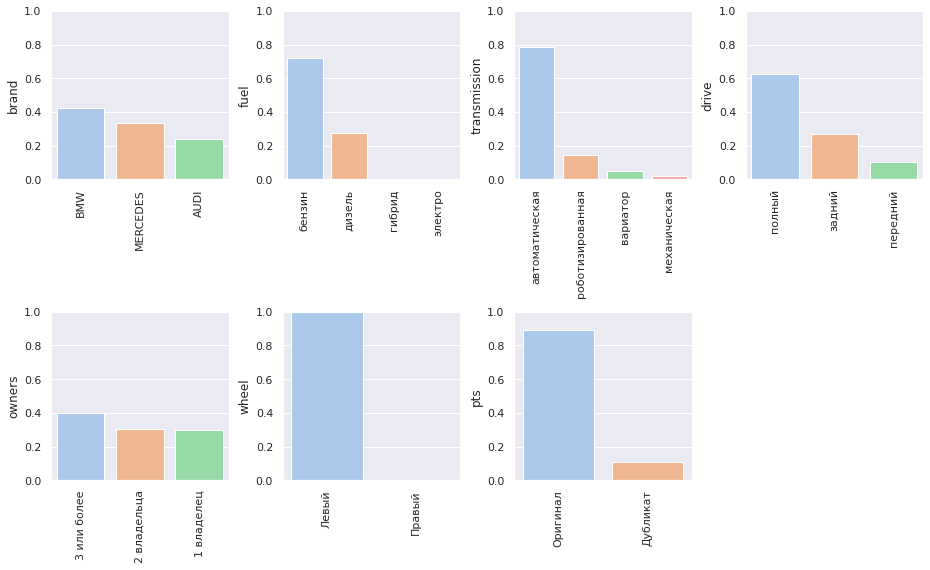

In [ ]:
cat_var = ['brand', 'fuel', 'transmission', 'drive', 'owners', 'wheel', 'pts']

fig = plt.figure(figsize=(13, 8))
for index, col in enumerate(cat_var):
    plt.subplot(2, 4, index+1)
    plt.xticks(rotation='vertical')
    f = sns.barplot(x = df.loc[:, cat_var][col].value_counts(normalize=True).index, 
                y = df.loc[:, cat_var][col].value_counts(normalize=True), palette = "pastel")
    f.set(ylim=(0, 1))
fig.tight_layout(pad=1.0)

Some observations:

* The most popular car brand in our dataset is BMW, the leas popular - Audi;
* Benzin & Diesel are by far the most frequent fuel types;
* Automatic transmissions prevail
* The vast majority of vehicles has the steering wheel on the left hand side.

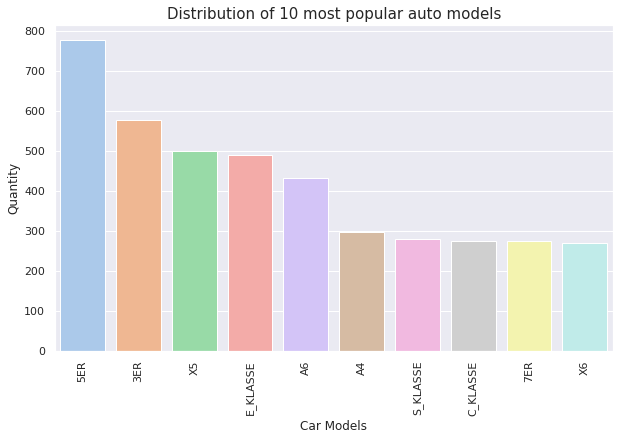

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df.model.value_counts()[:10].index, y=df.model.value_counts()[:10].values, palette = "pastel")
plt.title("Distribution of 10 most popular auto models", fontsize=15)
plt.xticks(rotation='90')
plt.xlabel("Car Models")
plt.ylabel("Quantity")
plt.show()

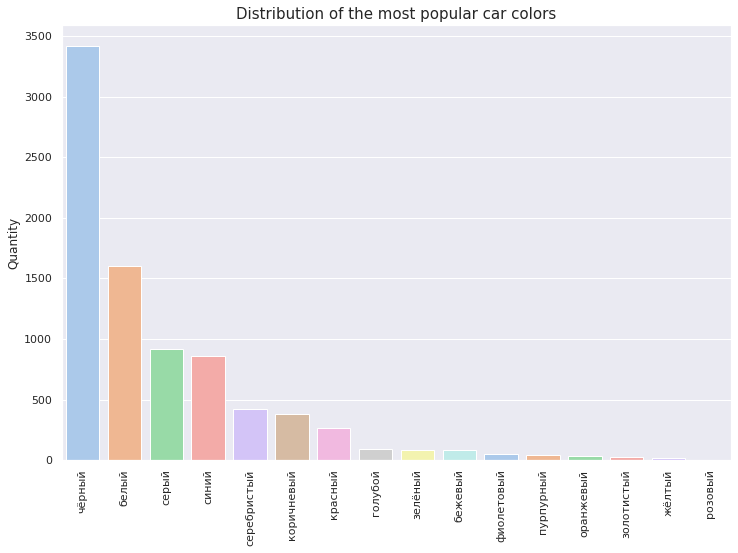

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x=df.color.value_counts().index, y=df.color.value_counts().values, palette = "pastel")
plt.title("Distribution of the most popular car colors", fontsize=15)
plt.xticks(rotation='90')
plt.ylabel("Quantity")
plt.show()

#### Multimodal data analysis

As a next step, we conduct a miltivariate data analysis to discovere relationships between variables. 

In [ ]:
df.head(2)

,body_type,brand,color,description,en_vol,en_power,fuel,mileage,model_date,model,num_doors,price,prod_date,sell_id,transmission,owners,pts,drive,wheel,train
0,внедорожник 5 дв.,BMW,чёрный,«Inchcape Certified- Первый международный офи...,2.0 LTR,190.0,дизель,8760,2017,X3,5,3125000.0,2020,1099116363,автоматическая,1 владелец,Оригинал,полный,Левый,1
1,седан,BMW,чёрный,"Авто в отличном состоянии, я второй собственни...",2.5 LTR,218.0,бензин,168000,2007,5ER,4,850000.0,2009,1099915110,автоматическая,2 владельца,Оригинал,задний,Левый,1


In [ ]:
num_var = df.select_dtypes(['float64', 'int']).columns.to_list()

In [ ]:
num_var

['en_power',
 'mileage',
 'model_date',
 'num_doors',
 'price',
 'prod_date',
 'sell_id',
 'train']

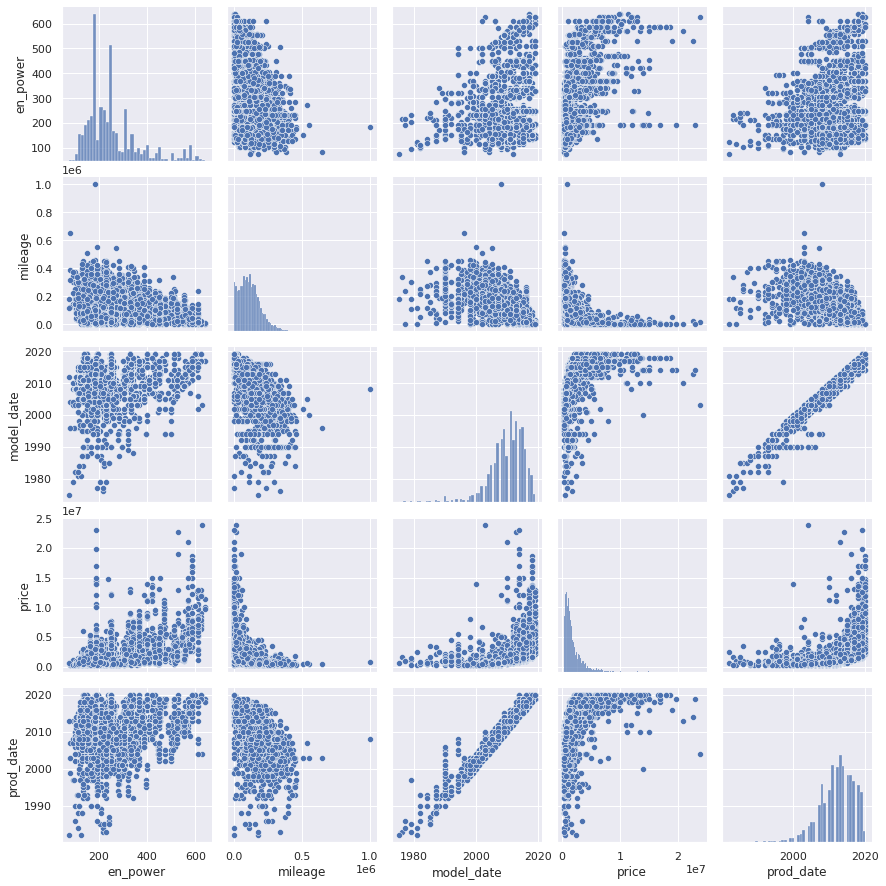

In [ ]:
sns.pairplot(train_df.loc[:, num_var].drop(['sell_id', 'train', 'num_doors'], 1))
plt.show()

Some observations:

* positive correlation between engine power and production & model date
* strong positive correlation between model & production date (we might drop one of these variables to tackle multicollinearity)
* slight positive correlation between price and production date

We can now check our assumptions by means of a good old correlation matrix.

In [ ]:
corr_matrix = train_df.loc[:, num_var].drop(['num_doors', 'train', 'sell_id'], 1).corr(method='spearman')
display(corr_matrix)

,en_power,mileage,model_date,price,prod_date
en_power,1.000000,-0.121062,0.051573,0.415447,0.028080
mileage,-0.121062,1.000000,-0.747169,-0.755038,-0.775078
model_date,0.051573,-0.747169,1.000000,0.801169,0.962898
price,0.415447,-0.755038,0.801169,1.000000,0.812721
prod_date,0.028080,-0.775078,0.962898,0.812721,1.000000


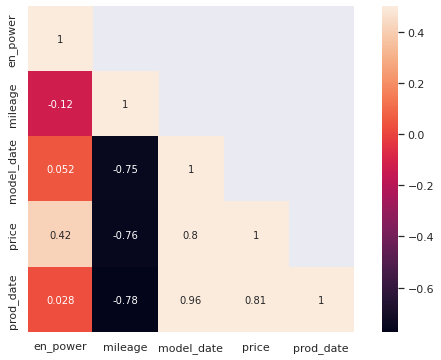

In [ ]:
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
sns.heatmap(corr_matrix, mask=mask, vmax=.5, square=True, annot=True)

* slightly stronger correlation between price and production date than between price and model date, so we should drop `model_date` to avoid multicollinearity
* strong negative correlation between mileage and price
* as well as between mileage and production date
+ mileage, model date and engine power seem to have the strongest impact on our target variable among numeric variables

Further, we investigate relationships btw some of our categorical variables and the trarget.

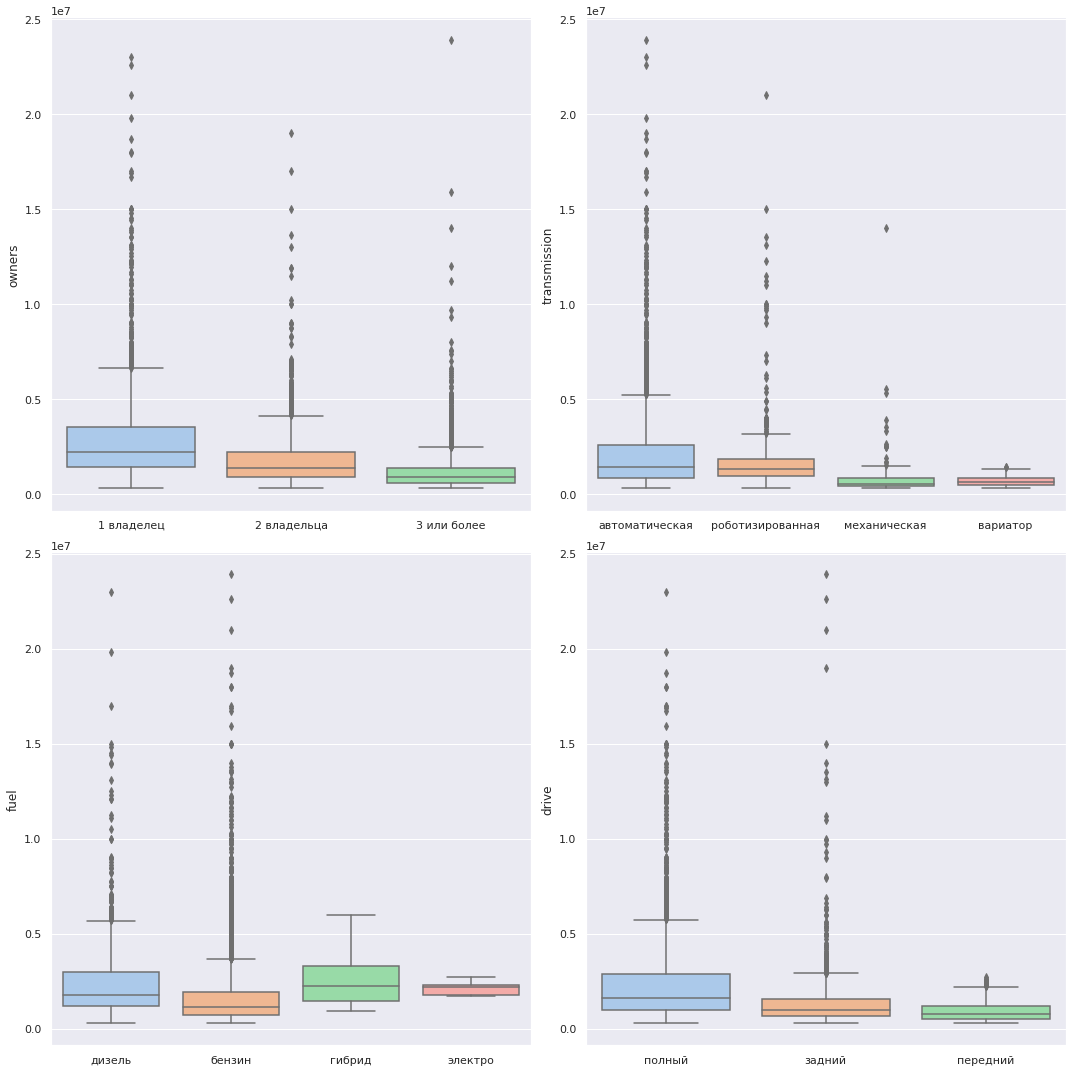

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

for idx, feat in enumerate(['owners', 'transmission', 'fuel', 'drive']):
    ax = axes[int(idx / 2), idx % 2]
    sns.boxplot(x=feat, y='price', data=train_df, ax=ax, palette = "pastel")
    ax.set_xlabel("")
    ax.set_ylabel(feat)
fig.tight_layout()
plt.show()

Vehicles with all wheels drive and with only one owner tend to sell at higher prices.

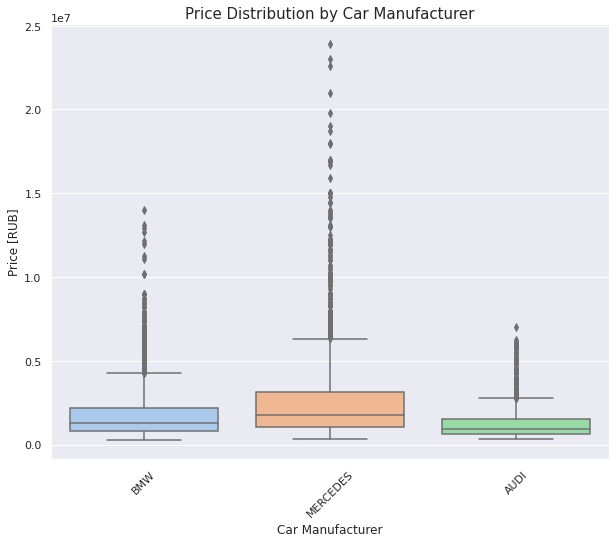

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="brand", y="price", data=train_df, palette = "pastel")
plt.title("Price Distribution by Car Manufacturer", fontsize=15)
plt.xticks(rotation='45')
plt.xlabel('Car Manufacturer')
plt.ylabel('Price [RUB]')
plt.show()

Cars produced by Mercedes tend to cost more than those of Audi and BMW

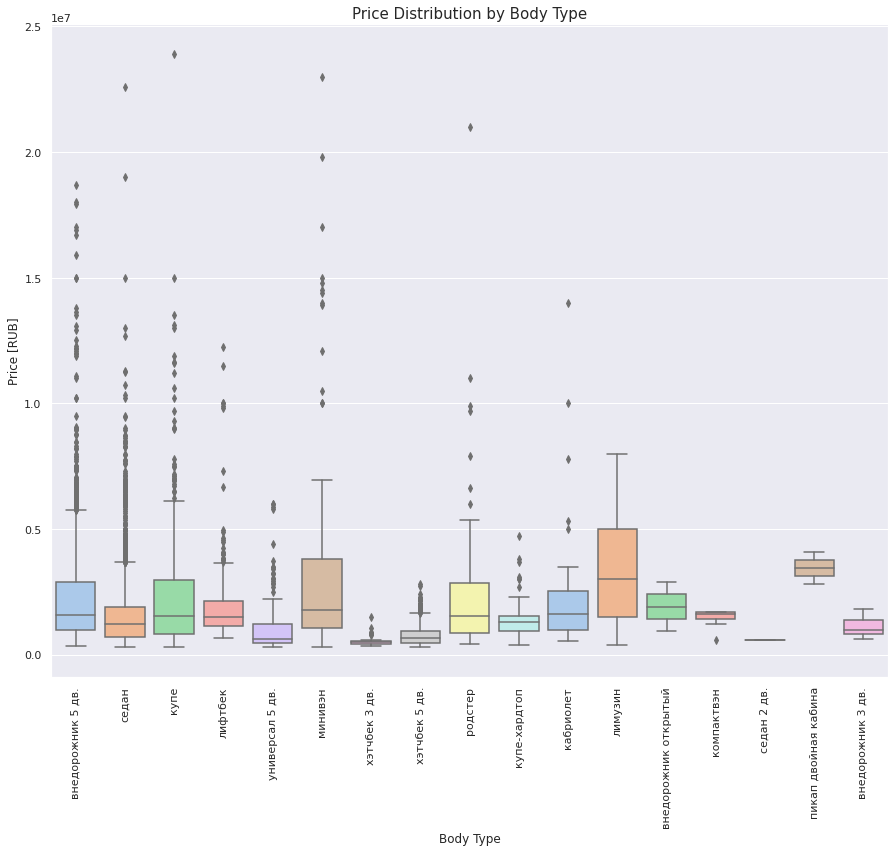

In [ ]:
plt.figure(figsize=(15, 12))
sns.boxplot(x='body_type', y="price", data=train_df, palette = "pastel")
plt.title("Price Distribution by Body Type", fontsize=15)
plt.xticks(rotation='90')
plt.xlabel('Body Type')
plt.ylabel('Price [RUB]')
plt.show()

limousines and pickups are more expensive on average

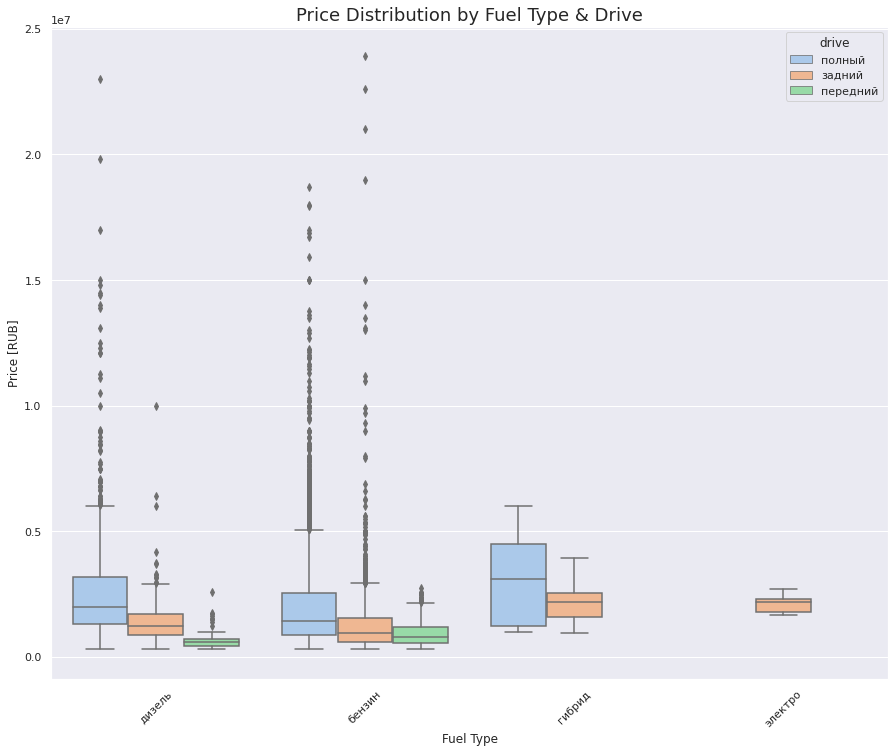

In [ ]:
plt.figure(figsize=(15, 12))
plt.xticks(rotation='45')
ax = sns.boxplot(x="fuel", y="price", hue='drive', data=train_df, palette = "pastel")
ax.set(xlabel='Fuel Type', ylabel='Price [RUB]')
ax.set_title('Price Distribution by Fuel Type & Drive', fontsize=18)
plt.show()

Cars with hybrid & electro power trains and all wheels drive tend to be more expensive. The least expensive cars tend to have rear wheels drive. 

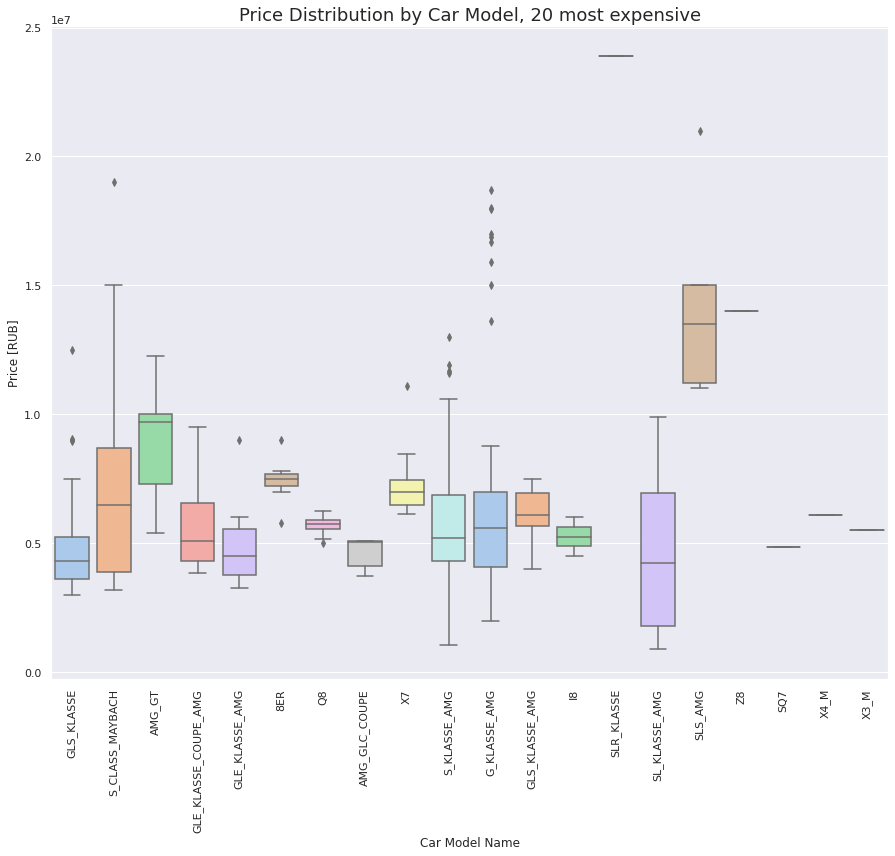

In [ ]:
# 20 most expensive models: boxplot
most_expensive_models = train_df.groupby('model')['price'].median().sort_values(ascending=False)[:20].index.to_list()
data = train_df[train_df['model'].isin(most_expensive_models)]

plt.figure(figsize=(15, 12))
plt.xticks(rotation='90')
ax = sns.boxplot(x="model", y="price", data=data, palette = "pastel")
ax.set(xlabel='Car Model Name', ylabel='Price [RUB]')
ax.set_title('Price Distribution by Car Model, 20 most expensive', fontsize=18)
plt.show()

Mercedes Models SLS AMG and AMG GT are the most expensive car models in our dataset.

### BASELINE MODEL

Let's now build a simple baseline model, which score we then will try to improve.

In [ ]:
X = train_df.copy().drop(['train', 'description', 'sell_id'], 1)
y = X.pop('price')

cat_features = X.select_dtypes(["category", "object"]).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

In [ ]:
# check our predictors
X.head()

,body_type,brand,color,en_vol,en_power,fuel,mileage,model_date,model,num_doors,prod_date,transmission,owners,pts,drive,wheel
0,внедорожник 5 дв.,BMW,чёрный,2.0 LTR,190.0,дизель,8760,2017,X3,5,2020,автоматическая,1 владелец,Оригинал,полный,Левый
1,седан,BMW,чёрный,2.5 LTR,218.0,бензин,168000,2007,5ER,4,2009,автоматическая,2 владельца,Оригинал,задний,Левый
2,седан,BMW,чёрный,4.4 LTR,450.0,бензин,152000,2012,7ER,4,2013,автоматическая,2 владельца,Оригинал,полный,Левый
3,седан,BMW,чёрный,2.5 LTR,192.0,бензин,45000,1987,5ER,4,1995,автоматическая,1 владелец,Оригинал,задний,Левый
4,седан,MERCEDES,белый,1.6 LTR,156.0,бензин,135000,2014,C_KLASSE,4,2014,автоматическая,3 или более,Оригинал,задний,Левый


In [ ]:
# check our target
y[:10]

0    3125000.0
1     850000.0
2    1250000.0
3    2200000.0
4    1068000.0
5    1050000.0
6    1676000.0
7    2500000.0
8     980000.0
9    1599000.0
Name: price, dtype: float64

In [ ]:
# we will use CatBoost to avoid dealing with categorical variables encoding
model_baseline = CatBoostRegressor(iterations = 5000,
                                   random_seed = 12,
                                   cat_features=cat_features,
                                   eval_metric='MAPE',
                                   custom_metric=['RMSE', 'MAE'],
                                   od_wait=500,
                                   task_type='GPU')

In [ ]:
model_baseline.fit(X_train, y_train,
                   eval_set=(X_test, y_test),
                   verbose_eval=100,
                   use_best_model=True)

Learning rate set to 0.037408


0:	learn: 0.9857389	test: 1.0009819	best: 1.0009819 (0)	total: 52ms	remaining: 4m 19s
100:	learn: 0.3580044	test: 0.3352597	best: 0.3352597 (100)	total: 3.17s	remaining: 2m 33s
200:	learn: 0.2828639	test: 0.2686593	best: 0.2685449 (199)	total: 6.18s	remaining: 2m 27s
300:	learn: 0.2524316	test: 0.2441711	best: 0.2441711 (300)	total: 9.13s	remaining: 2m 22s
400:	learn: 0.2318383	test: 0.2283050	best: 0.2283050 (400)	total: 12.2s	remaining: 2m 19s
500:	learn: 0.2187976	test: 0.2201392	best: 0.2201392 (500)	total: 15.1s	remaining: 2m 15s
600:	learn: 0.2059021	test: 0.2106291	best: 0.2105119 (585)	total: 18s	remaining: 2m 11s
700:	learn: 0.2006470	test: 0.2073266	best: 0.2073266 (700)	total: 20.6s	remaining: 2m 6s
800:	learn: 0.1963820	test: 0.2043545	best: 0.2040877 (793)	total: 23.3s	remaining: 2m 2s
900:	learn: 0.1905758	test: 0.1989619	best: 0.1989380 (899)	total: 26.1s	remaining: 1m 58s
1000:	learn: 0.1883932	test: 0.1972449	best: 0.1971830 (990)	total: 28.7s	remaining: 1m 54s
1100:	l

In [ ]:
# create MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    The function gets true values & predicted values
    and calculates mean absolute percentage error.
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [ ]:
test_predict_catboost = model_baseline.predict(X_test)
baseline_model_mape = mean_absolute_percentage_error(y_test, test_predict_catboost)
print(f"TEST mape: {baseline_model_mape*100:0.2f}%")

TEST mape: 18.21%


### FEATURE ENGINEERING

#### Inventing new features

We now move to one of the most important parts in data science workflow - feature engineering.

Firstly, we add a few new variables based on our EDA insights.


In [ ]:
# display first rows of our dataset
df.head()

,body_type,brand,color,description,en_vol,en_power,fuel,mileage,model_date,model,num_doors,price,prod_date,sell_id,transmission,owners,pts,drive,wheel,train
0,внедорожник 5 дв.,BMW,чёрный,«Inchcape Certified- Первый международный офи...,2.0 LTR,190.0,дизель,8760,2017,X3,5,3125000.0,2020,1099116363,автоматическая,1 владелец,Оригинал,полный,Левый,1
1,седан,BMW,чёрный,"Авто в отличном состоянии, я второй собственни...",2.5 LTR,218.0,бензин,168000,2007,5ER,4,850000.0,2009,1099915110,автоматическая,2 владельца,Оригинал,задний,Левый,1
2,седан,BMW,чёрный,"Автомобиль в прекрасном рабочем состоянии, сде...",4.4 LTR,450.0,бензин,152000,2012,7ER,4,1250000.0,2013,1095029130,автоматическая,2 владельца,Оригинал,полный,Левый,1
3,седан,BMW,чёрный,"Продам bmw 525 в кузове Е34, в редком лимитир...",2.5 LTR,192.0,бензин,45000,1987,5ER,4,2200000.0,1995,1097910892,автоматическая,1 владелец,Оригинал,задний,Левый,1
4,седан,MERCEDES,белый,Mercedes Benz 2014года выпуска.........ПТС ори...,1.6 LTR,156.0,бензин,135000,2014,C_KLASSE,4,1068000.0,2014,1100133868,автоматическая,3 или более,Оригинал,задний,Левый,1


In [ ]:
# combine brand name & car body type
df['brand_body'] = df['brand'] + '_' + df['body_type']

In [ ]:
# combine brand name & drive type
df['brand_drive'] = df['brand'] + '_' + df['drive']

In [ ]:
# median mileage for each model 
df['medianmileage_model'] = round(df.groupby('model')['mileage'].transform('median'), 3)

In [ ]:
# miles per year
df['miles_per_year'] = round(df['mileage'] / (2022 - df['prod_date']), 3)

In [ ]:
# median engine power for each model
df['medianpower_model'] = round(df.groupby('model')['en_power'].transform('median'), 3)

In [ ]:
# miles per year
df['miles_per_year'] = round(df['mileage'] / (2021 - df['prod_date']), 3)

In [ ]:
# combine fuel type & drive type
df['fuel_drive'] = df['fuel'] + '_' + df['drive']

In [ ]:
# median engine power for each fuel type
df['medianpower_fuel'] = round(df.groupby('fuel')['en_power'].transform('median'), 3)

In [ ]:
# drop model_date (multicollinearity)
df.drop('model_date', 1, inplace=True)

#### Encoding of categorical variables

We now encode our categorical variables using one-hot-encoding.

In [ ]:
# select all categorical variables except 'description'
cat_features = df.select_dtypes('object').nunique().sort_values()[:-1].index.to_list()

In [ ]:
# data shape before one-hot-encoding
df.shape

(8290, 26)

In [ ]:
df.drop(['description', 'sell_id'], 1, inplace=True)
df = pd.get_dummies(df, columns=cat_features, dummy_na=False)

In [ ]:
# data shape after one-hot-encoding
df.shape

(8290, 286)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head()

,en_power,mileage,num_doors,price,prod_date,train,medianmileage_model,miles_per_year,medianpower_model,medianpower_fuel,pts_Дубликат,pts_Оригинал,wheel_Левый,wheel_Правый,brand_AUDI,brand_BMW,brand_MERCEDES,owners_1 владелец,owners_2 владельца,owners_3 или более,drive_задний,drive_передний,drive_полный,fuel_бензин,fuel_гибрид,fuel_дизель,fuel_электро,transmission_автоматическая,transmission_вариатор,transmission_механическая,transmission_роботизированная,brand_drive_AUDI_передний,brand_drive_AUDI_полный,brand_drive_BMW_задний,brand_drive_BMW_передний,brand_drive_BMW_полный,brand_drive_MERCEDES_задний,brand_drive_MERCEDES_передний,brand_drive_MERCEDES_полный,fuel_drive_бензин_задний,...,model_S6,model_S7,model_S8,model_SLC_KLASSE,model_SLC_KLASSE_AMG,model_SLK_KLASSE,model_SLK_KLASSE_AMG,model_SLR_KLASSE,model_SLS_AMG,model_SL_KLASSE,model_SL_KLASSE_AMG,model_SQ5,model_SQ7,model_S_CLASS_MAYBACH,model_S_KLASSE,model_S_KLASSE_AMG,model_TT,model_TTS,model_VIANO,model_VITO,model_V_KLASSE,model_W123,model_W124,model_W201,model_X1,model_X2,model_X3,model_X3_M,model_X4,model_X4_M,model_X5,model_X5_M,model_X6,model_X6_M,model_X7,model_X_KLASSE,model_Z1,model_Z3,model_Z3M,model_Z4
0,190.0,8760,5,3125000.0,2020,1,125500.0,8760.000,192.0,235.0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,218.0,168000,4,850000.0,2009,1,132000.0,14000.000,218.0,230.0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,450.0,152000,4,1250000.0,2013,1,109131.0,19000.000,320.0,230.0,0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,192.0,45000,4,2200000.0,1995,1,132000.0,1730.769,218.0,230.0,0,1,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,156.0,135000,4,1068000.0,2014,1,88137.0,19285.714,156.0,230.0,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Excellent! We now have no categorical variables in our dataset!

#### Scaling data

In [ ]:
X = df.drop(['train', 'price'], 1)
col_names = X.columns.to_list()

In [ ]:
# scaling features usind RodustScaler
trans = RobustScaler()
X_scaled = pd.DataFrame(trans.fit_transform(X.loc[:, col_names]), columns=col_names)

# trans = StandardScaler()
# X_scaled = pd.DataFrame(trans.fit_transform(X.loc[:, col_names]), columns=col_names)

# trans = MinMaxScaler()
# X_scaled = pd.DataFrame(trans.fit_transform(X.loc[:, col_names]), columns=col_names)

In [ ]:
X_scaled = X_scaled.astype(np.float32)

In [ ]:
X_scaled.describe()

,en_power,mileage,num_doors,prod_date,medianmileage_model,miles_per_year,medianpower_model,medianpower_fuel,pts_Дубликат,pts_Оригинал,wheel_Левый,wheel_Правый,brand_AUDI,brand_BMW,brand_MERCEDES,owners_1 владелец,owners_2 владельца,owners_3 или более,drive_задний,drive_передний,drive_полный,fuel_бензин,fuel_гибрид,fuel_дизель,fuel_электро,transmission_автоматическая,transmission_вариатор,transmission_механическая,transmission_роботизированная,brand_drive_AUDI_передний,brand_drive_AUDI_полный,brand_drive_BMW_задний,brand_drive_BMW_передний,brand_drive_BMW_полный,brand_drive_MERCEDES_задний,brand_drive_MERCEDES_передний,brand_drive_MERCEDES_полный,fuel_drive_бензин_задний,fuel_drive_бензин_передний,fuel_drive_бензин_полный,...,model_S6,model_S7,model_S8,model_SLC_KLASSE,model_SLC_KLASSE_AMG,model_SLK_KLASSE,model_SLK_KLASSE_AMG,model_SLR_KLASSE,model_SLS_AMG,model_SL_KLASSE,model_SL_KLASSE_AMG,model_SQ5,model_SQ7,model_S_CLASS_MAYBACH,model_S_KLASSE,model_S_KLASSE_AMG,model_TT,model_TTS,model_VIANO,model_VITO,model_V_KLASSE,model_W123,model_W124,model_W201,model_X1,model_X2,model_X3,model_X3_M,model_X4,model_X4_M,model_X5,model_X5_M,model_X6,model_X6_M,model_X7,model_X_KLASSE,model_Z1,model_Z3,model_Z3M,model_Z4
count,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,...,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000,8290.000000
mean,0.188443,0.086789,0.262967,-0.147304,-0.272582,0.057199,0.335959,0.262099,0.105911,-0.105911,-0.000241,0.000241,0.237877,0.425211,0.336912,0.298794,0.302292,0.398914,0.271170,0.105669,-0.376840,-0.279614,0.001689,0.277201,0.000724,-0.215199,0.048975,0.022316,0.143908,0.079011,0.158866,0.164174,0.002051,0.258987,0.106996,0.024608,0.205308,0.228709,0.098191,0.393486,...,0.000483,0.000724,0.001206,0.000362,0.000121,0.002774,0.000241,0.000121,0.000121,0.002413,0.001206,0.000241,0.000121,0.004704,0.033776,0.007117,0.003378,0.000362,0.005187,0.005066,0.006876,0.000121,0.001206,0.000121,0.019059,0.001327,0.032328,0.000121,0.008444,0.000483,0.060434,0.004584,0.032449,0.006876,0.002654,0.000362,0.000121,0.000362,0.000121,0.002533
std,0.876626,0.757264,0.882615,0.727569,0.806889,0.825586,1.215560,0.580646,0.307754,0.307754,0.015530,0.015530,0.425819,0.494385,0.472693,0.457748,0.459295,0.489722,0.444587,0.307436,0.484608,0.448817,0.041063,0.447631,0.026894,0.410984,0.215835,0.147721,0.351010,0.269777,0.365595,0.370469,0.045238,0.438084,0.309140,0.154940,0.403952,0.420041,0.297592,0.488554,...,0.021962,0.026894,0.034714,0.019022,0.010983,0.052602,0.015531,0.010983,0.010983,0.049060,0.034713,0.015530,0.010983,0.068434,0.180667,0.084065,0.058022,0.019021,0.071837,0.071002,0.082637,0.010983,0.034713,0.010982,0.136746,0.036406,0.176871,0.010983,0.091508,0.021962,0.238310,0.067554,0.177200,0.082637,0.051450,0.019021,0.010983,0.019021,0.010983,0.050271
min,-1.278689,-1.038121,-2.000000,-4.428571,-2.775000,-1.613456,-1.787500,-12.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

All our variables now have roughly the same scale with a median equals zero

#### Power transform

In [ ]:
cols_to_change = X.nunique().sort_values().tail(4).index.to_list()
cols_to_change

['medianmileage_model', 'en_power', 'mileage', 'miles_per_year']

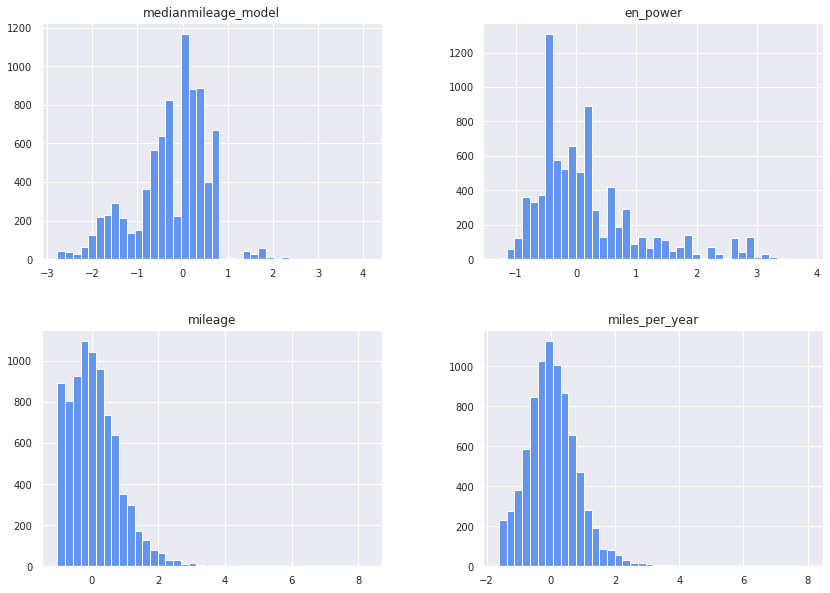

In [ ]:
X_scaled.loc[:, cols_to_change].hist(sharex=False, sharey=False, bins=40, xlabelsize=10, ylabelsize=10, 
                                                    figsize=(14, 10), color='cornflowerblue')
plt.show()

In [ ]:
power = PowerTransformer(method='yeo-johnson', standardize=False)

for feat in cols_to_change:
  X_scaled[feat] = power.fit_transform(np.array(X_scaled[feat]).reshape(-1, 1))

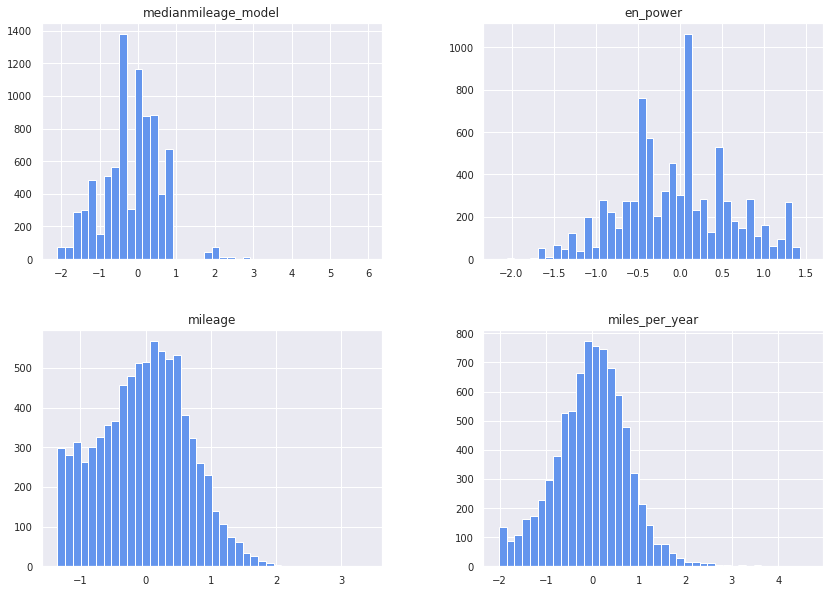

In [ ]:
X_scaled.loc[:, cols_to_change].hist(sharex=False, sharey=False, bins=40, xlabelsize=10, ylabelsize=10, 
                                                    figsize=(14, 10), color='cornflowerblue')
plt.show()

We brought our continious numbers variables closer to normal distriution.

In [ ]:
X_scaled['train'] = df['train']
X_scaled['price'] = df['price']

In [ ]:
df = X_scaled.copy()

#### Feature importance

As a next step, we will find out what features are most important in predicting our target using *mutual information*.

In [ ]:
X = df[df.train==1]
y = X.pop('price')

In [ ]:
def make_mi_scores(X, y):
    '''
    The function calculates mutual information scores for our variables.
    '''
    mi_scores = mutual_info_regression(X, y, discrete_features='auto')
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
X = X.round(2)
mi_scores = make_mi_scores(X, y)

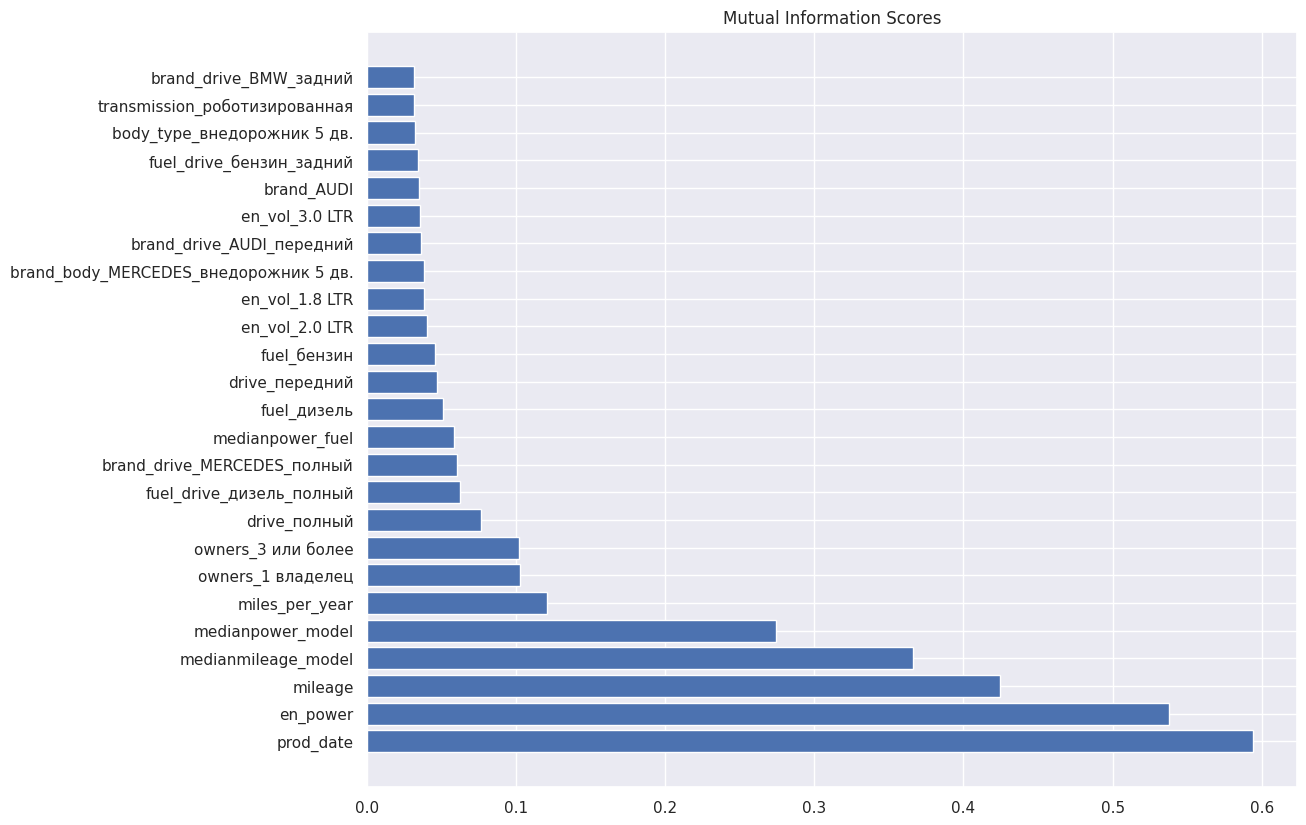

In [ ]:
def plot_mi_scores(scores):
    '''
    The function visualizes mutual information scores on a bar chart.
    '''
    scores = scores.sort_values(ascending=False)[:25]
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(12, 10))
plot_mi_scores(mi_scores)

In [ ]:
# show MI scores of 10 most important features
display(mi_scores[:10])

prod_date                   0.593903
en_power                    0.537638
mileage                     0.424503
medianmileage_model         0.366148
medianpower_model           0.274560
miles_per_year              0.120836
owners_1 владелец           0.102934
owners_3 или более          0.102262
drive_полный                0.076711
fuel_drive_дизель_полный    0.062712
Name: MI Scores, dtype: float64

In [ ]:
# remove 50 least important predictors
cols_to_drop = mi_scores[-51:].index.to_list()

In [ ]:
if 'train' in cols_to_drop:
  cols_to_drop.remove('train')
else:
  print('all fine!')

In [ ]:
df.drop(cols_to_drop, 1, inplace=True)

#### Bringing target distribution to normal

In [ ]:
# logarithm the target
price = np.log(df[df['train']==1].price)
df.loc[df['train']==1, 'price'] = price

In [ ]:
# trans = StandardScaler()
# price_log = np.log(df[df.train==1].price).to_numpy()
# df.loc[df.train==1, 'price'] = trans.fit_transform(price_log.reshape(-1, 1))
# df[df.train==1].price.plot(kind='hist', bins=30);

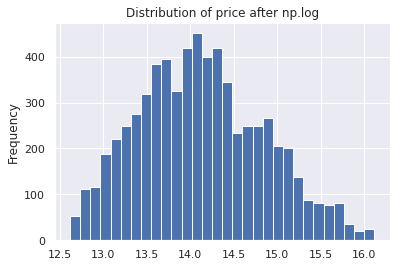

In [ ]:
plt.title('Distribution of price after np.log')
df[df.train==1].price.plot(kind='hist', bins=30);

### MODELLING (ML)

Let's now build another CatBoost model and train it on our preprocessed data.

In [ ]:
X = df[df.train==1].drop('train', 1)
y = X.pop('price')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

In [ ]:
model_catboost = CatBoostRegressor(iterations = 5000,
                          random_seed = 12,
                          # cat_features=cat_features,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          task_type='GPU')

In [ ]:
model_catboost.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True)

Learning rate set to 0.037391
0:	learn: 0.0403305	test: 0.0404276	best: 0.0404276 (0)	total: 18.9ms	remaining: 1m 34s


100:	learn: 0.0105660	test: 0.0111960	best: 0.0111960 (100)	total: 1.36s	remaining: 1m 5s
200:	learn: 0.0095260	test: 0.0102982	best: 0.0102982 (200)	total: 2.52s	remaining: 1m
300:	learn: 0.0091105	test: 0.0099548	best: 0.0099537 (299)	total: 3.63s	remaining: 56.6s
400:	learn: 0.0088276	test: 0.0097240	best: 0.0097240 (400)	total: 4.75s	remaining: 54.4s
500:	learn: 0.0086317	test: 0.0095843	best: 0.0095843 (500)	total: 5.86s	remaining: 52.6s
600:	learn: 0.0084822	test: 0.0094918	best: 0.0094918 (600)	total: 7s	remaining: 51.2s
700:	learn: 0.0083677	test: 0.0094142	best: 0.0094142 (700)	total: 8.18s	remaining: 50.1s
800:	learn: 0.0082796	test: 0.0093602	best: 0.0093602 (800)	total: 9.31s	remaining: 48.8s
900:	learn: 0.0081795	test: 0.0092922	best: 0.0092921 (898)	total: 10.5s	remaining: 47.6s
1000:	learn: 0.0081099	test: 0.0092539	best: 0.0092539 (1000)	total: 11.6s	remaining: 46.3s
1100:	learn: 0.0080394	test: 0.0092132	best: 0.0092129 (1093)	total: 12.7s	remaining: 45.1s
1200:	learn:

In [ ]:
# check validation results
test_predict_catboost = model_catboost.predict(X_test)
catboost_model_mape = mean_absolute_percentage_error(np.exp(y_test), np.exp(test_predict_catboost))
print(f"TEST mape: {(catboost_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"Baseline mape: {(baseline_model_mape)*100:0.2f}%")

TEST mape: 12.65%
##########
Baseline mape: 18.21%


Already a significant improvement over our baseline model!

#### Submission

In [ ]:
# train the model on the whole data
model_catboost.fit(X, y,
                   eval_set=(X, y),
                   verbose_eval=100,
                   use_best_model=True)

Learning rate set to 0.037819
0:	learn: 0.0402911	test: 0.0402911	best: 0.0402911 (0)	total: 14ms	remaining: 1m 10s


100:	learn: 0.0104312	test: 0.0104312	best: 0.0104312 (100)	total: 1.37s	remaining: 1m 6s
200:	learn: 0.0094049	test: 0.0094049	best: 0.0094049 (200)	total: 2.64s	remaining: 1m 3s
300:	learn: 0.0089644	test: 0.0089644	best: 0.0089644 (300)	total: 3.89s	remaining: 1m
400:	learn: 0.0086951	test: 0.0086951	best: 0.0086951 (400)	total: 5.16s	remaining: 59.1s
500:	learn: 0.0085103	test: 0.0085103	best: 0.0085103 (500)	total: 6.39s	remaining: 57.4s
600:	learn: 0.0083738	test: 0.0083738	best: 0.0083738 (600)	total: 7.62s	remaining: 55.8s
700:	learn: 0.0082954	test: 0.0082954	best: 0.0082954 (700)	total: 8.84s	remaining: 54.2s
800:	learn: 0.0082410	test: 0.0082410	best: 0.0082410 (800)	total: 10.1s	remaining: 52.8s
900:	learn: 0.0081872	test: 0.0081872	best: 0.0081872 (900)	total: 11.3s	remaining: 51.5s
1000:	learn: 0.0081075	test: 0.0081075	best: 0.0081075 (1000)	total: 12.6s	remaining: 50.2s
1100:	learn: 0.0080445	test: 0.0080445	best: 0.0080445 (1100)	total: 13.8s	remaining: 48.9s
1200:	lea

In [ ]:
# create Google Colab folder for submissions
!mkdir submission

mkdir: cannot create directory ‘submission’: File exists


In [ ]:
test_sub = df[df.train==0].drop(['train', 'price'], 1)
submission_predict_catboost = model_catboost.predict(test_sub)
submission = pd.read_csv('sample_submission.csv')
submission.loc[:, 'price'] = np.exp(submission_predict_catboost)
submission.to_csv('submission/submission_catboost.csv', index=False)

### SIMPLE NEURAL NETWORK

We now build a simple neural network and train it on our preprocessed tabular data

In [ ]:
# neural nets didn't perform well with np.log(target)
# bring target to its original form
y_train = np.exp(y_train)
y_test = np.exp(y_test)
y = np.exp(y)

In [ ]:
# create a model
model_nn1 = tf.keras.Sequential()
model_nn1.add(layers.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_nn1.add(layers.Dropout(0.5))
model_nn1.add(layers.Dense(256, activation="relu"))
model_nn1.add(layers.Dropout(0.5))
model_nn1.add(layers.Dense(1))

In [ ]:
# check model's summary
model_nn1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               120320    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 251,905
Trainable params: 251,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# check shape of our input data
X_train.shape, X_test.shape

((5295, 234), (1324, 234))

In [ ]:
# compile the model
model_nn1.compile(loss='MAPE',
                  optimizer=Adam(learning_rate=.01), 
                  metrics=['MAPE'])

In [ ]:
# create callbacks
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='project_checkpoint_weights/checkpoint.ckpt',
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=0)

earlystop = EarlyStopping(monitor='val_MAPE', patience=20, restore_best_weights=True)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_MAPE",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=5,
                                                 verbose=0, 
                                                 min_lr=1e-7)

callbacks_list = [checkpoint_callback, reduce_lr, earlystop]

In [ ]:
history = model_nn1.fit(X_train, y_train,
                        batch_size=512,
                        epochs=500,
                        validation_data=(X_test, y_test),
                        callbacks=callbacks_list,
                        verbose=0)

In [ ]:
test_predict_nn1 = model_nn1.predict(X_test)
nn1_model_mape = mean_absolute_percentage_error(y_test, test_predict_nn1[:,0])
print(f"TEST mape: {(nn1_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"CatBoost model mape: {(catboost_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"Baseline model mape: {(baseline_model_mape)*100:0.2f}%")

TEST mape: 12.37%
##########
CatBoost model mape: 12.65%
##########
Baseline model mape: 18.21%


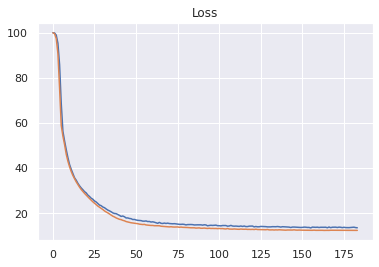

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

#### Submission

In [ ]:
submission_predict_nn1 = model_nn1.predict(test_sub)
submission.loc[:, 'price'] = submission_predict_nn1
submission.to_csv('submission/submission_nn1.csv', index=False)

### NEURAL LANGUAGE PROCESSING

Now we build an NLP network which predicts vehicles' prices based on their descriptions stored in `description` variable.

We start with preprocessing our text data:

* remove all russian stop words from text,
* bring words in their normal form,
* remove punctuation &
* remove all digits from text 

In [ ]:
# download stopwords corpus, you need to run it once
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")

In [ ]:
#Preprocess function
def preprocess_text(text):
  '''
  This function takes as input a text sentence in str format and: 
  1) removes all russian stop words from it,
  2) brings the words in normal form,
  3) removes punctuation &
  4) removes all digits from the string
  '''

  text = text.split(' ')
  tokens = [morph.parse(w.lower())[0].normal_form for w in text]
  tokens = [token.translate(str.maketrans('', '', punctuation)).translate(str.maketrans('', '', digits)) for token in tokens if token not in russian_stopwords and token != " "]
  text = ' '.join(tokens)
    
  return text

In [ ]:
train_txt = train_df[['description', 'price']]
test_txt = test_df[['description', 'price']]

In [ ]:
train_sentences = train_txt.description.to_list()
test_sentences = test_txt.description.to_list()

In [ ]:
%%time
train_txt['description'] = train_txt.description.apply(lambda x: preprocess_text(x))
print('prepricessing of train data ready')
test_txt['description'] = test_txt.description.apply(lambda x: preprocess_text(x))
print('prepricessing of test data ready')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


prepricessing of train data ready
prepricessing of test data ready
CPU times: user 3min 33s, sys: 212 ms, total: 3min 33s
Wall time: 3min 33s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# check a random sentence
np.random.choice(train_txt.description.to_list())

'индивидуальный автомобиль который подарить завистливый взгляд положительный эмоций\nотличный экономичный нологовый мотор  tdi  лс\nотличный состояние\n\nгарантия юридический чистота автомобиль  обмен свой ам пробег наш ам пробегом дополнительный скидка выбрать автомобиль   рубпереть покупка автомобиль кредит дополнительный скидка   рубавтомобиль представить автосалон атлантм тушино официальный дилер skoda наш сотрудник дать подробный информация технический состояние автомобиля включая состояние лакокрасочный покрытие автомобиль проверка юридический чистотыинформация проверить визит наш дилерский центр необходимый оборудование проверка предоставим кредит  подробность узнать менеджер кредитностраховой отделавнимание просьба предварительно связываться менеджер приездом'

In [ ]:
# Split data into train & test splits
text_train = train_txt.description.iloc[X_train.index].to_numpy()
text_test = train_txt.description.iloc[X_test.index].to_numpy()

In [ ]:
# for future submission
text_sub = test_txt.description.to_numpy()

In [ ]:
# find the average number of tokens (words) in the training tweets
avg_length = round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))
print(avg_length)

115


In [ ]:
# collect lenghts of each description (in words) in a list
sentences_lens = []
for txt in train_df["description"].to_numpy():
  sentences_lens.append(len(txt.split(' ')))

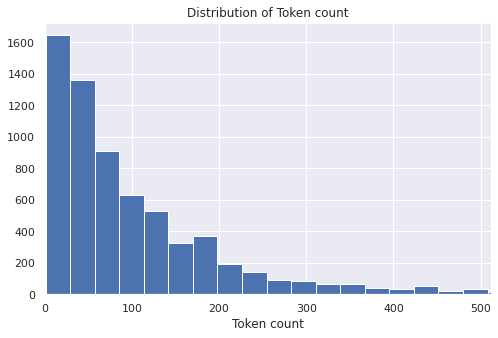

In [ ]:
sns.set(rc={'figure.figsize':(8, 5)})
plt.title('Distribution of Token count')
plt.hist(sentences_lens, bins=50)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [ ]:
# setup text vectorization variables
max_vocab_length = 200000
max_length = 256

In [ ]:
# instantiate & fit Tokenizer
tokenize = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_length)
tokenize.fit_on_texts(train_txt.description)

In [ ]:
# apply the Tokenizer to our train & test (preprocessed) text data
text_train_sequences = tf.keras.preprocessing.sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=max_length)
text_test_sequences = tf.keras.preprocessing.sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=max_length)

In [ ]:
# same for submission data
tokenize.fit_on_texts(test_txt.description)
text_sub_sequences = tf.keras.preprocessing.sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=max_length)

In [ ]:
# create NLP model with two LSTM layers without head
model_nlp = tf.keras.Sequential()
model_nlp.add(layers.Input(shape=max_length, name="seq_description"))
model_nlp.add(layers.Embedding(len(tokenize.word_index)+1, max_length))
model_nlp.add(layers.LSTM(256, return_sequences=True))
model_nlp.add(layers.Dropout(0.5))
model_nlp.add(layers.LSTM(128,))
model_nlp.add(layers.Dropout(0.25))
model_nlp.add(layers.Dense(64, activation="relu"))
model_nlp.add(layers.Dropout(0.25))

In [ ]:
# create a simple neural network with two hidden layers (no head)
model_mlp = tf.keras.Sequential()
model_mlp.add(layers.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(layers.Dropout(0.5))
model_mlp.add(layers.Dense(256, activation="relu"))
model_mlp.add(layers.Dropout(0.5))

In [ ]:
# combine our models
combinedInput = layers.concatenate([model_nlp.output, model_mlp.output,])

head = layers.Dense(64, activation="relu")(combinedInput)
head = layers.Dense(1, activation="linear")(head)

model_nn2 = tf.keras.Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
# compile the model
model_nn2.compile(loss='MAPE',
                  optimizer=Adam(0.3),
                  metrics=['MAPE'])

In [ ]:
# fit the model
history = model_nn2.fit([text_train_sequences, X_train], y_train,
                         batch_size=512,
                         epochs=500,
                         validation_data=([text_test_sequences, X_test], y_test),
                         callbacks=callbacks_list,
                         verbose=0)

In [ ]:
test_predict_nn2 = model_nn2.predict([text_test_sequences, X_test])
nn2_model_mape = mean_absolute_percentage_error(y_test, test_predict_nn2[:,0])
print(f"TEST mape: {(nn2_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"Simple neural network mape: {(nn1_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"CatBoost model mape: {(catboost_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"Baseline model mape: {(baseline_model_mape)*100:0.2f}%")

TEST mape: 11.93%
##########
Simple neural network mape: 12.37%
##########
CatBoost model mape: 12.65%
##########
Baseline model mape: 18.21%


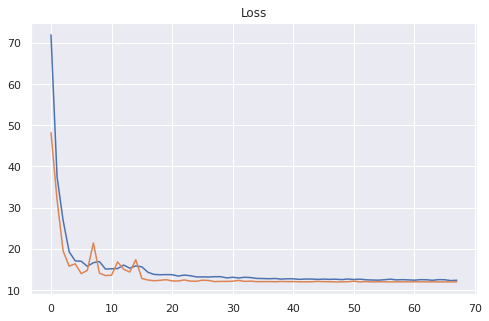

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

#### Submission

In [ ]:
submission_predict_nn2 = model_nn2.predict([text_sub_sequences, test_sub])
submission.loc[:, 'price'] = submission_predict_nn2
submission.to_csv('submission/submission_nn2.csv', index=False)

### PRETRAINED SENTENCE ENCODER

In our next experiment, we are going to leverage pretrained embeddings through transfer learning. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the [Universal Sentence Encoder from TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3).

In [ ]:
# load Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [ ]:
sample_sentence = np.random.choice(text_train)
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.04962884  0.06524012  0.04668792  0.03919956 -0.07152365  0.01671378
 -0.08160508 -0.02384862 -0.06134163 -0.01776614 -0.03787334 -0.03889666
  0.05705793  0.04407665  0.02171391  0.01703616  0.04076107 -0.0717124
  0.00516141  0.06632654 -0.06136946  0.04021358  0.05666847  0.05173112
  0.0434429  -0.04554505 -0.03419372 -0.06292307  0.03061068 -0.03044638
  0.00884063  0.08815987  0.01399163 -0.03930628  0.01208849 -0.028226
  0.05516627  0.03692164 -0.03561039  0.06396003 -0.05572766 -0.07790603
 -0.01881514 -0.00438128  0.07267085 -0.04076906  0.05707558  0.0813285
 -0.00683628 -0.01796294], shape=(50,), dtype=float32)


In [ ]:
# create keras layer using USE pretrained layer from Tensor Hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [ ]:
# create model using Sequential API
model_nlp_pretrained = tf.keras.Sequential([
                       sentence_encoder_layer,
                       layers.Dense(64, activation='relu')                
                       ], name='model_nlp_USE')

In [ ]:
combinedInput = layers.concatenate([model_nlp_pretrained.output, model_mlp.output])

head = layers.Dense(64, activation="relu")(combinedInput)
head = layers.Dense(1, activation="linear")(head)

model_nn3 = tf.keras.Model(inputs=[model_nlp_pretrained.input, model_mlp.input], outputs=head)

In [ ]:
model_nn3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_20_input (InputLayer)     [(None, 234)]        0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 512)          120320      dense_20_input[0][0]             
__________________________________________________________________________________________________
USE_input (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 512)          0           dense_20[0][0]                   
____________________________________________________________________________________________

In [ ]:
# compile the model
model_nn3.compile(loss='MAPE',
                  optimizer=Adam(0.1),
                  metrics=['MAPE'])

In [ ]:
# fit the model
history = model_nn3.fit([text_train, X_train], y_train,
                         batch_size=512,
                         epochs=500,
                         validation_data=([text_test, X_test], y_test),
                         callbacks=callbacks_list,
                         verbose=0)

In [ ]:
# check validation results
test_predict_nn3 = model_nn3.predict([text_test, X_test])
nn3_model_mape = mean_absolute_percentage_error(y_test, test_predict_nn3[:,0])
print(f"TEST mape: {(nn3_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"Custom NLP model mape: {(nn2_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"Simple neural network mape: {(nn1_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"CatBoost model mape: {(catboost_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"Baseline model mape: {(baseline_model_mape)*100:0.2f}%")

TEST mape: 12.27%
##########
Custom NLP model mape: 11.93%
##########
Simple neural network mape: 12.37%
##########
CatBoost model mape: 12.65%
##########
Baseline model mape: 18.21%


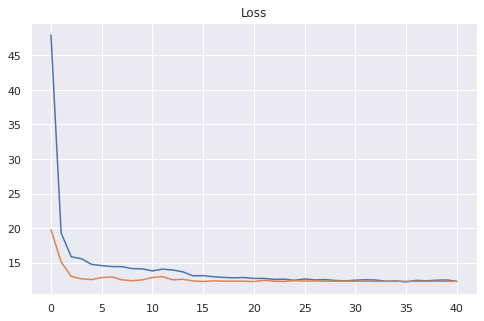

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

Our pretrained Universal Sentence Encoder has performed slightly better than our simple neural network. However, it failed to outperform the custom NLP model.

#### Submission

In [ ]:
submission_predict_nn3 = model_nn3.predict([text_sub, test_sub])
submission.loc[:, 'price'] = submission_predict_nn3
submission.to_csv('submission/submission_nn3.csv', index=False)

### COMPUTER VISION

We now try to use the visual information from our dataset to train a CNN-model with a pretrained layer. We then combine output of the simple NN, NLP NN & a new CNN-based model into one single head see how our mean absulute percentage error changes.

#### Get data

In [ ]:
# set image size
size = (320, 240)

In [ ]:
data = test_df.append(train_df, sort=False).reset_index(drop=True) 
print(train_df.shape, test_df.shape, data.shape)

(6682, 20) (1671, 20) (8353, 20)


In [ ]:
def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread('img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

In [ ]:
images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(test_sub.index)

images shape (5295, 240, 320, 3) dtype uint8
images shape (1324, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


In [ ]:
images_train.shape, images_test.shape, images_sub.shape

((5295, 240, 320, 3), (1324, 240, 320, 3), (1671, 240, 320, 3))

#### Data augmentation & preparation

Since we are working with a rather small dataset, a good idea would be to artificially enlarge our visual dataset through data augmentation.

In [ ]:
augmentation = Compose([
    OneOf([
      RandomContrast(limit=0.2, p=0.5),
      GridDistortion(p=0.1),
      MotionBlur(p=0.2),
    ], p=0.2),                    
    HorizontalFlip(),
    GaussNoise(),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    HueSaturationValue(p=0.3),
], p=1)

In [ ]:
def make_augmentations(images):
  print('applying augmentation', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [ ]:
def process_image(image):
    return augmentation(image=image.numpy())['image']

def tokenize_(descriptions):
  return tf.keras.preprocessing.sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = max_length)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

In [ ]:
# prepare training data
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, train_txt.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

In [ ]:
# preparing validation data
test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, train_txt.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

In [ ]:
# for submission predictions:
y_sub = np.zeros(len(test_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, test_sub, test_txt.description.iloc[test_sub.reset_index().index], y_sub
    )).map(tf_process_val_dataset_element)

In [ ]:
# check for errors
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

#### Creating models

In [ ]:
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = layers.GlobalAveragePooling2D()(efficientnet_model.output)

In [ ]:
tabular_model = tf.keras.Sequential([
    layers.Input(shape = X_train.shape[1]),
    layers.Dense(512, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(0.5),
    ])

In [ ]:
nlp_model = tf.keras.Sequential([
    layers.Input(shape=max_length, name="seq_description"),
    layers.Embedding(len(tokenize.word_index)+1, max_length,),
    layers.LSTM(256, return_sequences=True),
    layers.Dropout(0.5),
    layers.LSTM(128),
    layers.Dropout(0.25),
    layers.Dense(64),
    ])

In [ ]:
combinedInput = layers.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

head = layers.Dense(256, activation="relu")(combinedInput)
head = layers.Dense(1,)(head)

model_nn4 = tf.keras.Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)

#### Compile, fit & validate

In [ ]:
# compile the model
model_nn4.compile(loss='MAPE',
              optimizer=Adam(.01),
              metrics=['MAPE'])

In [ ]:
# fit the model
history = model_nn4.fit(train_dataset.batch(32),
                        # batch_size=512,
                        epochs=35,
                        validation_data=test_dataset.batch(32),
                        callbacks=callbacks_list)

Epoch 1/35
166/166 [==============================] - 217s 1s/step - loss: 43.0443 - MAPE: 43.0443 - val_loss: 20.6075 - val_MAPE: 20.6075
Epoch 2/35
166/166 [==============================] - 201s 1s/step - loss: 17.9660 - MAPE: 17.9660 - val_loss: 15.2184 - val_MAPE: 15.2184
Epoch 3/35
166/166 [==============================] - 200s 1s/step - loss: 15.4873 - MAPE: 15.4873 - val_loss: 13.9876 - val_MAPE: 13.9876
Epoch 4/35
166/166 [==============================] - 200s 1s/step - loss: 14.7600 - MAPE: 14.7600 - val_loss: 13.7878 - val_MAPE: 13.7878
Epoch 5/35
166/166 [==============================] - 200s 1s/step - loss: 14.2345 - MAPE: 14.2345 - val_loss: 13.5373 - val_MAPE: 13.5373
Epoch 6/35
166/166 [==============================] - 199s 1s/step - loss: 14.0649 - MAPE: 14.0649 - val_loss: 13.1044 - val_MAPE: 13.1044
Epoch 7/35
166/166 [==============================] - 200s 1s/step - loss: 13.9784 - MAPE: 13.9784 - val_loss: 12.8234 - val_MAPE: 12.8234
Epoch 8/35
166/166 [=======

In [ ]:
test_predict_nn4 = model_nn4.predict(test_dataset.batch(32))
nn4_model_mape = mean_absolute_percentage_error(y_test, test_predict_nn4[:, 0])
print(f"TEST mape: {(nn4_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"NLP pretrained model mape: {(nn3_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"Custom NLP model mape: {(nn2_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"Simple neural network mape: {(nn1_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"CatBoost model mape: {(catboost_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"Baseline model mape: {(baseline_model_mape)*100:0.2f}%")

TEST mape: 12.07%
##########
NLP pretrained model mape: 12.27%
##########
Custom NLP model mape: 11.93%
##########
Simple neural network mape: 12.37%
##########
CatBoost model mape: 12.65%
##########
Baseline model mape: 18.21%


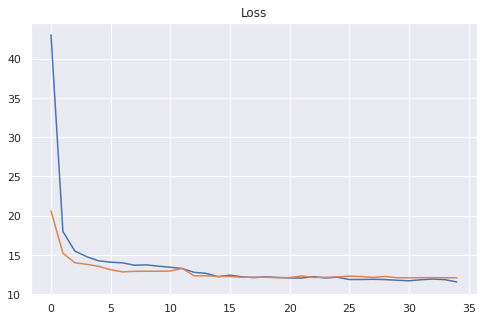

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

No sign of overfitting as both train & validation loss curves gradually drop to their minimum at 12 per cent.

In [ ]:
# save model
model_nn4.save('saved_model_nn4.h5')

INFO:tensorflow:Assets written to: saved_model_nn4/assets


INFO:tensorflow:Assets written to: saved_model_nn4/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# # load model with custom hub layer
# loaded_model_nn4 = tf.keras.models.load_model('saved_model_nn4.h5',
#                                                custom_objects={'KerasLayer': hub.KerasLayer}) # our pretrained layer

Let's combine predictions from our ML model & ensemble neural networks model

In [ ]:
blend_predict = (np.exp(test_predict_catboost) + test_predict_nn4[:,0]) / 2
combined_model_mape = mean_absolute_percentage_error(y_test, blend_predict)
print(f"Combined mape: {(combined_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"Ensemble Simple + RNN + CNN mape: {(nn4_model_mape)*100:0.2f}%")
print('#' * 10)
print(f"CatBoost model mape: {(catboost_model_mape)*100:0.2f}%")

Combined mape: 11.91%
##########
Ensemble Simple + RNN + CNN mape: 12.07%
##########
CatBoost model mape: 12.65%


Using some advanced DL techniques, we managed to reach a MAPE of 11.91% which is quite a significant improvement over our baseline model. We are now ready to submit predictions.

#### Submission

In [ ]:
submission_predict_nn4 = model_nn4.predict(sub_dataset.batch(32))
sub_blend_predict = (np.exp(submission_predict_catboost) + submission_predict_nn4[:,0]) / 2

In [ ]:
submission.loc[:, 'price'] = sub_blend_predict
submission.to_csv('submission/submission_nn4.csv', index=False)

In [ ]:
sub_blend_predict_2 = (submission_predict_nn2[:,0] + submission_predict_nn4[:,0]) / 2
submission.loc[:, 'price'] = (np.round(sub_blend_predict_2 / 100)) * 100
submission.to_csv('submission/submission_nn4_nn2_2.csv', index=False)

In [ ]:
sub_blend_predict_2[:,0].shape

(1671,)

In [ ]:
submission.head(10)

,sell_id,price
0,1099427284,439700.0
1,1096405886,2778300.0
2,1100195294,637600.0
3,1099827282,491800.0
4,1100076198,2841700.0
5,1090159352,2802600.0
6,1098987386,1690200.0
7,1098639040,1519300.0
8,1099933039,1090000.0
9,1099565572,499600.0
